In [1]:
#set some constants
DATASETFILE = '/path/to/dataFile'
ITEMSPERCAMERA = 10
YRANDOM=1024
CAMERAS=2
DROPPED=0
CMC=100
EXPERIMENTS=100

In [2]:
from pelops.datasets.featuredataset import FeatureDataset
from pelops.experiment_api.experiment import ExperimentGenerator
from pelops.analysis import analysis


#do the math
featureData = FeatureDataset(DATASETFILE)
expGen = ExperimentGenerator(featureData, CAMERAS, ITEMSPERCAMERA, DROPPED, YRANDOM)
experimentHolder = analysis.repeat_pre_cmc(featureData,expGen,NUMCMC=CMC,EXPPERCMC=EXPERIMENTS)
stats,gdata = analysis.make_cmc_stats(experimentHolder,ITEMSPERCAMERA)

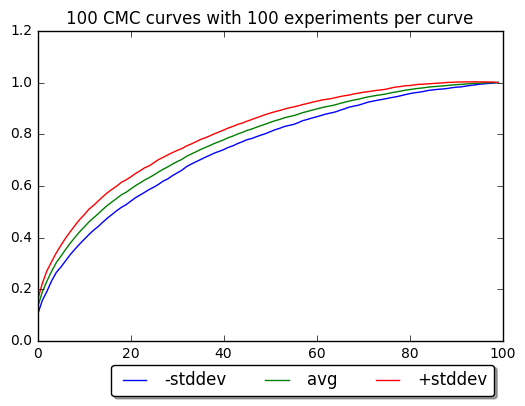

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

#make the plots
fig = plt.figure()
ax = plt.subplot(111)

ax.plot(gdata.transpose())
plt.title('{} CMC curves with {} experiments per curve'.format(CMC,EXPERIMENTS))
ax.legend(('-stddev','avg','+stddev'),bbox_to_anchor=(1, -0.05),
          fancybox=True, shadow=True, ncol=5)